In [18]:
from manim import *
import jupyter_capture_output
import matplotlib.pyplot as plt
from numpy import linalg as npl

video_scene = " -v WARNING --disable_caching cat_behaviour_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s cat_behaviour_Scene"

In [3]:
main_color = WHITE
bg_color = BLACK
red_color = RED
blue_color = BLUE

grey1 = LIGHT_GREY
grey2 = GRAY
grey3 = DARK_GRAY


# light mode
# main_color = BLACK
# bg_color = WHITE
# red_color = PURE_RED
# blue_color = PURE_BLUE

# grey1 = DARK_GREY
# grey2 = GRAY
# grey3 = LIGHT_GRAY

In [4]:
# potential
def get_potential(g, delta):
    def potential(x):
        return g * (x**2-1) * x**2 * (x**2-delta) / (x**2+delta)
    return potential


# verlet maruyama
class VerletMaruyama():
    def __init__(self, potential, bool_params, force_params, delta_t, **kwargs):
        super().__init__(**kwargs)

        self.potential = potential
        self.bool_epsilon = bool_params[0]
        self.bool_sigma = bool_params[1]
        self.epsilon = force_params[0]
        self.sigma = force_params[1]
        self.mass = force_params[2]
        self.delta_t = delta_t

    # calculates nex integration step
    def step(self, state):
        x = state[0]
        vx = state[1]
        potential_force = -(self.potential(x+0.001)-self.potential(x-0.001))

        # support acceleration a1
        a1 = potential_force / self.mass                               # calculate potential force into a1
        if (self.bool_epsilon):
            a1 -= self.epsilon*vx / self.mass                     # adjust a1 by friction
        if (self.bool_sigma):
            a1 += np.random.normal(0, self.sigma) / self.mass              # adjust a1 by gaussian noise
        x += vx*self.delta_t + a1*self.delta_t**2/2
        # support acceleration a2
        a2 = potential_force / self.mass 
        if (self.bool_epsilon):
            a2 -= self.epsilon*vx / self.mass                      # adjust a2 by friction
        if (self.bool_sigma):
            a2 += np.random.normal(0, self.sigma) / self.mass               # adjust a2 by gaussian noise
        vx += (a1 + a2) * self.delta_t/2
        return np.array([x, vx])

In [5]:
class CatPotential(Mobject):
    def __init__(self, potential_center = np.array([0, 0, 0]), nline_center = np.array([0, -2, 0]), x_length = 4, y_length = 2, g = 1, delta = 1, **kwargs):
        super().__init__(**kwargs)

        # number plane for potential
        self.npla = NumberPlane(
            x_range = [-1.3, 1.3], y_range = [-0.05, 0.2], x_length = x_length, y_length = y_length,
            x_axis_config = {"stroke_opacity": 1, "stroke_color": grey2}, y_axis_config = {"stroke_opacity": 1, "stroke_color": grey2}, background_line_style = {"stroke_opacity": 0.25, "stroke_color": grey2}
            ).move_to(potential_center)
        npla_xlabel = self.npla.get_x_axis_label(Tex(r"$x$", font_size = 28, color = main_color))
        npla_ylabel = self.npla.get_y_axis_label(Tex(r"$V(x)$", font_size = 28, color = main_color))#.shift(1.05 * LEFT + 0.15 * DOWN)
        
        # draw potential
        self.cat_potential = get_potential(g, delta)
        drawn_potential = self.npla.plot(self.cat_potential, x_range = [-1.15, 1.15], stroke_width = 4, stroke_color = grey1)
        
        # number line for potential
        self.nline = NumberLine(x_range = [-1.3, 1.3], length = x_length, color = grey2).move_to(nline_center)
        nline_xlabel = Tex(r"$x$", font_size = 28, color = main_color).next_to(self.nline, 0.5*UR + 0.375*DOWN)

        self.add(self.npla, npla_xlabel, npla_ylabel, self.nline, drawn_potential, nline_xlabel)

        # cat
        self.cat = ImageMobject("../external_media/cat1.png")

    
    def get_cat(self, x):
        Vx = self.cat_potential(x)
        V_circle = Circle(radius = 0.05, color = red_color).move_to(self.npla.c2p(x, Vx))
        Cat = self.cat.move_to(self.nline.n2p(x))
        connector = DashedLine(start = self.npla.c2p(x, Vx), end = self.nline.n2p(x), stroke_color = main_color, dash_length = 0.05, dashed_ratio = 0.5)
        return [Cat, V_circle, connector]


class CatPosition(Mobject):
    def __init__(self, center = np.array([0, 0, 0]), x_length = 4, y_length = 2, **kwargs):
        super().__init__(**kwargs)

        # number plane for postion over time
        self.npla = NumberPlane(
            x_range = [0, 7500, 250], y_range = [-1.3, 1.3], x_length = x_length, y_length = y_length,
            x_axis_config = {"stroke_opacity": 1, "stroke_color": grey2}, y_axis_config = {"stroke_opacity": 1, "stroke_color": grey2}, background_line_style = {"stroke_opacity": 0.25, "stroke_color": grey2}
        ).move_to(center)
        npla_xlabel = self.npla.get_x_axis_label(Tex(r"$t$", font_size = 28, color = main_color))
        npla_ylabel = self.npla.get_y_axis_label(Tex(r"$x$", font_size = 28, color = main_color))#.shift(1.05 * LEFT + 0.15 * DOWN)
        self.add(self.npla, npla_xlabel, npla_ylabel)


    def c2p(self, x, y):
        return self.npla.c2p(x, y)
    

    def get_dot(self, t, x):
        tx_circle_pos = self.npla.c2p(t, x)
        tx_circle = Circle(radius = 0.05, color = red_color).move_to(tx_circle_pos)
        tx_circle.pos = tx_circle_pos
        return tx_circle
    

In [7]:
%%manim -qh --fps 60 $video_scene


class cat_behaviour_Scene(Scene):
    def construct(self):
        self.camera.background_color = bg_color

        CVC = Text('CVC', font_size = 12, weight = BOLD, color = WHITE, font = 'Latin Modern Sans').align_on_border(RIGHT + DOWN, buff = 0.2)
        self.add(CVC)

        headline = Title(r"Bewegungsgleichung einer Katze", font_size = 48, color = main_color).align_on_border(UP + LEFT, buff = 0.5).shift(0.5 * RIGHT)
        headline.underline.set_color(main_color)
        self.add(headline)

        # seed !!!
        np.random.seed(3)

        # potential parameters
        g = 1
        delta = 0.5


        # left side
        x_center = -3
        potential = CatPotential(potential_center = np.array([x_center, 0.5, 0]), nline_center = np.array([x_center, -2.5, 0]), x_length = 5, y_length = 2.5, g = g, delta = delta)
        self.add(potential)

        # right side
        position_time = CatPosition(center = np.array([3, -0.5, 0]), x_length = 4, y_length = 4)
        self.add(position_time)


        # initial conditions
        x = -0.5
        vx = 0.025
        state = np.array([x, vx])
        state_list = []

        # integration parameters
        t = 0
        T = 10
        delta_t = 0.1
        t_list = []

        cat = potential.get_cat(x)
        actual_cat = cat[0]
        cat_group = cat[1]
        tx_circle = position_time.get_dot(t, x)
        tx_circle.pos = [t, x]
        self.add(cat[2], cat[1], cat[0], tx_circle)


        # physical parameters
        epsilon_friction = 0.25
        sigma_noise = 0.045
        m_mass = 1

        # boolean params
        bool_friction = 1
        bool_noise = 1

        # integration
        verlet = VerletMaruyama(get_potential(g, delta), [1, 1], [epsilon_friction, sigma_noise, m_mass], delta_t)
        while (t <= 10000*T):
            state = verlet.step(state)
            state_list.append(state)
            t += delta_t
            t_list.append(t)
        
        speed = 20
        t_iter = iter(t_list[::speed])
        state_iter1 = iter(state_list[::speed])
        state_iter2 = iter(state_list[::speed])
        state_iter25 = iter(state_list[::speed])
        state_iter3 = iter(state_list[::speed])


        def cat_updater(cat):
            new_state = next(state_iter1)
            x = new_state[0]
            new_cat = potential.get_cat(x)[0]
            cat.become(new_cat)

        def cat2_updater(cat_dot):
            new_state = next(state_iter2)
            x = new_state[0]
            new_cat = potential.get_cat(x)[1]
            cat_dot.become(new_cat)

        def cat3_updater(cat_dot):
            new_state = next(state_iter25)
            x = new_state[0]
            new_cat = potential.get_cat(x)[2]
            cat_dot.become(new_cat)

        def time_updater(circle):
            t = next(t_iter)
            new_state = next(state_iter3)
            x = new_state[0]
            new_circle = position_time.get_dot(t, x)
            line = Line(start = circle.get_center(), end = new_circle.pos, color = red_color, stroke_width = 1)
            self.add(line)
            circle.become(new_circle)


        t_tracker = ValueTracker(0)
        cat[0].add_updater(cat_updater)
        cat[1].add_updater(cat2_updater)
        cat[2].add_updater(cat3_updater)
        tx_circle.add_updater(time_updater)
        self.play(t_tracker.animate.set_value(T), rate_func = linear, run_time = 60)
        self.wait(5)


Manim Community v0.18.1

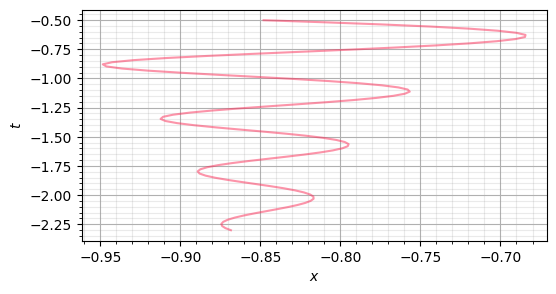

(-0.8480019810968872, -0.5009)
(-0.8092809117601235, -0.5189)
(-0.7742127412520673, -0.5369)
(-0.7441616681730869, -0.5549)
(-0.7199138979970358, -0.5728999999999999)
(-0.7018347071423477, -0.5908999999999998)
(-0.6900117739989257, -0.6088999999999998)
(-0.6843649341837551, -0.6268999999999997)
(-0.6847175491057301, -0.6448999999999996)
(-0.6908319859510398, -0.6628999999999999)
(-0.7024140220888683, -0.6809000000000002)
(-0.7190911347203067, -0.6989000000000004)
(-0.740369775456406, -0.7169000000000006)
(-0.7655782867071121, -0.7349000000000009)
(-0.7938058018202658, -0.7529000000000012)
(-0.8238530410554961, -0.7709000000000015)
(-0.8542166937238289, -0.7889000000000017)
(-0.8831315996865969, -0.806900000000002)
(-0.9086895088807226, -0.8249000000000022)
(-0.9290361382012845, -0.8429000000000024)
(-0.9426207918299158, -0.8609000000000027)
(-0.9484441968316857, -0.8789000000000029)
(-0.9462358356018065, -0.8969000000000031)
(-0.9365046568926457, -0.9149000000000035)
(-0.92044570066873

In [30]:
# trajection calculation for LaTeX

# algorithm control parameters
t = 0
T = 200
delta_t = 0.1


# potential parameters
g = 2
delta = 0.4

# physical cat parameters
epsilon_friction = 0.02
sigma_noise = 0
m_mass = 1

# boolean params
bool_friction = 1
bool_noise = 0


# integration
verlet = VerletMaruyama(get_potential(g, delta), [bool_friction, bool_noise], [epsilon_friction, sigma_noise, m_mass], delta_t)
state_list = []
t_list = []
state = np.array([-0.85, 0.02])
while (t <= T):
    state = verlet.step(state)
    state_list.append(state)
    t += delta_t
    t_list.append(t)


t_list, state_list


# plotting
fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlabel(r'$x$')      # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
ax.set_ylabel(r'$t$')
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()
ax.plot([state_list[i][0] for i in range(0, len(t_list), int(T/10))], [-0.5-t_list[i]/T*2*0.9 for i in range(0, len(t_list), int(T/10))], color = "xkcd:red pink", alpha = 0.5)
plt.show()

for i in range(0, len(t_list), int(T/10)):
    print(f"({state_list[i][0]}, {-0.5-t_list[i]/T*2*0.9})")